**Hello World Example**

_This notebook is partly based on Chapter 3 of Aurelien Geron: Hand-on Machine Learning with Scikit-learn & Tensorflow._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import gc

def reset_graph():
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.set_random_seed(42)
    sess = K.get_session()
    K.clear_session()
    sess.close()
    sess = K.get_session()
    gc.collect()
    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    K.set_session(tf.compat.v1.Session(config=config))

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
NB_ID = "VGG_MNIST"

# create the directory if it does not exist
os.makedirs(os.path.join(PROJECT_ROOT_DIR, "images", NB_ID), exist_ok = True)
        
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", NB_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

# Import the Keras API from Tensorflow

In [3]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras import backend as K

# MNIST

MNIST is the hello world example of machine learning. scikit-learn can load the data directly from https://www.openml.org. 

In [4]:
import math
from sklearn.datasets import fetch_openml

X,y = fetch_openml('mnist_784',version=1,cache=True,return_X_y=True)
X = X.values
y = y.values
# Use the notion of y=f(X)
y = y.astype(int)
print('Data size: {0} x {1} and label size {2}'.format(X.shape[0],X.shape[1],y.shape[0]))
print('The images are of size: {0} x {0}'.format(math.sqrt(X.shape[1])))

Data size: 70000 x 784 and label size 70000
The images are of size: 28.0 x 28.0


# Test and Training Data
Let's split into training images and test images.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0/7, stratify=y, random_state=42)

# shuffle_index = np.random.permutation(70000)
# reshuffle the data and use 60000 samples as training and 10000 as test
# X_train, X_test, y_train, y_test = X[shuffle_index[:60000],:], X[shuffle_index[60000:],:], y[shuffle_index[:60000]], y[shuffle_index[60000:]]

# reshape into images
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

print('Matrix shape X: ', X_train.shape)
print('{0} samples for training'.format(X_train.shape[0]))
print('{0} samples for training'.format(X_test.shape[0]))

Matrix shape X:  (60000, 28, 28, 1)
60000 samples for training
10000 samples for training


Plot an image as sanity check.

Number:  7


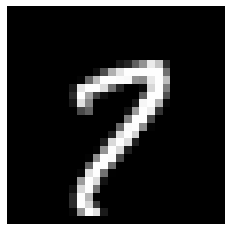

In [6]:
plot_image(X_train[15000,:,:,0])
print('Number: ', y_train[15000])

For VGG net, we will need colour images of minimum size $32 \times 32$

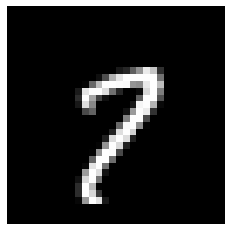

In [7]:
from skimage.color import gray2rgb

def resize_images(X_in):
    X_32 = np.zeros((X_in.shape[0],32,32,3))
    for i in range(0,X_in.shape[0]):
        X_32[i,2:30,2:30] = gray2rgb(X_in[i,:,:,0])
    return X_32
    

X_train_32 = resize_images(X_train)
X_test_32 = resize_images(X_test)
    
plot_color_image(X_train_32[15000])


# VGG-16
Import VGG net but without the top fully connected layers. We like to put our own classification layer on top. We will keep VGG net fix and just train our won top layers.

In [8]:
from tensorflow.keras.applications import VGG16
    
    
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))



58889256/58889256 [==============================] - 0s 0us/step


In [9]:
print(vgg_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Add new output layer

In [ ]:
vgg_model.layers[-1]

In [ ]:
for layer in vgg_model.layers:
    layer.trainable = False

# We will have to use the functional API    

# last layers output
x = vgg_model.layers[-1].output
# Flatten as before
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

from tensorflow.keras.models import Model
vgg_model_transfer = Model(inputs=vgg_model.input, outputs=x)


In [ ]:
print(vgg_model_transfer.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Turn the numbers into one-hot vectors

In [10]:
nClasses = 10
# Use Keras' handy utils
y_train_k = tensorflow.keras.utils.to_categorical(y_train, num_classes=nClasses)
y_test_k = tensorflow.keras.utils.to_categorical(y_test, num_classes=nClasses)


See if it worked

In [ ]:
for i in range(0,200,20):
    print(y_train[i], " ", y_train_k[i,:])


6   [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
3   [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1   [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
2   [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
9   [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
5   [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
1   [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
6   [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
2   [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
5   [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# MNIST Training

In [ ]:
batchSize = 128
nEpochs = 5

from keras import backend as K

reset_graph()

sgd = tensorflow.keras.optimizers.SGD(lr=0.0008)
vgg_model_transfer.compile(loss='categorical_crossentropy', 
                           optimizer=sgd, 
                           metrics=['accuracy'])

history = vgg_model_transfer.fit(X_train_32, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(X_test_32, y_test_k))


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/5
469/469 [==============================] - 22s 25ms/step - loss: 1.0771 - accuracy: 0.7266 - val_loss: 0.5798 - val_accuracy: 0.8216
Epoch 2/5
469/469 [==============================] - 11s 23ms/step - loss: 0.4912 - accuracy: 0.8480 - val_loss: 0.4569 - val_accuracy: 0.8578
Epoch 3/5
469/469 [==============================] - 12s 25ms/step - loss: 0.3954 - accuracy: 0.8765 - val_loss: 0.3689 - val_accuracy: 0.8871
Epoch 4/5
469/469 [==============================] - 11s 23ms/step - loss: 0.3460 - accuracy: 0.8917 - val_loss: 0.3430 - val_accuracy: 0.8940
Epoch 5/5
469/469 [==============================] - 11s 24ms/step - loss: 0.3154 - accuracy: 0.8999 - val_loss: 0.3295 - val_accuracy: 0.8948


In [ ]:
y_predict_prob = vgg_model_transfer.predict(X_test_32)

313/313 [==============================] - 3s 8ms/step


In [ ]:
y_predict = y_predict_prob.argmax(axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_predict)
print('Confusion matrix: \n{0}'.format(conf_mx))

Confusion matrix: 
[[ 967    0    0    0    2    1    7    1    1    7]
 [   0 1090    0    1   12    1    1   18    1    1]
 [   7    2  840   35   11   17   10   28   43    6]
 [   3    0   25  950    1    9    2    7   22    1]
 [   0   17   10    7  887    5    7   29    5    8]
 [   8    1   43  180    7  607   20    7   25    4]
 [  13    5   20    4   17   12  897    2    2   10]
 [   0    9   20    4   29    0    0  961    9   10]
 [   2    0   26   39    8    1    4    4  877   14]
 [  18    7   21   11   12    3    3   18   29  872]]


In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure VGGtransfer_confusion_matrix_errors


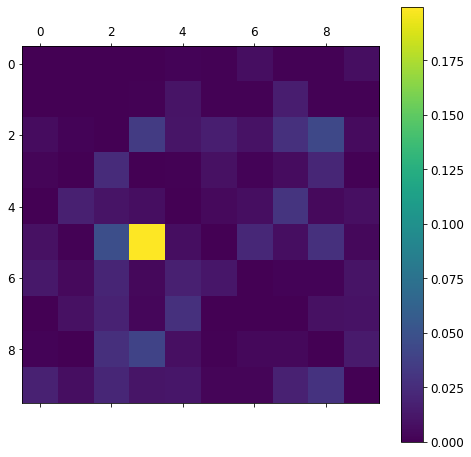

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
save_fig("VGGtransfer_confusion_matrix_errors", tight_layout=False)
plt.show()

# Training History Visualization 

**Accuracy**
Source: Keras manual

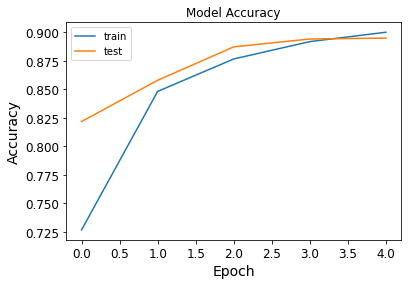

In [ ]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


**Loss**
Source: Keras manual

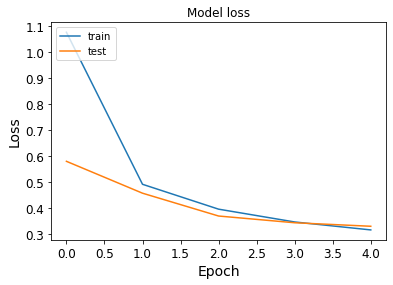

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

